In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.constants as ac
import astropy.units as au
import os,re
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200


In [4]:
# import all that needed to handle Athena's vtk outputs
from vtk_reader import *

In [5]:
# currently, the data is downloadable from 
# http://tigress-web.princeton.edu/~changgoo/TIGRESS_example_data/R8_8pc_rst.0300.vtk
# http://tigress-web.princeton.edu/~changgoo/TIGRESS_example_data/R8_2pc_rst-mid.0300.vtk
# fname='./R8_8pc_rst.0300.vtk'
# fname='./R8_2pc_rst-mid.0300.vtk'
fname = '/Users/ckim/Research/TIGRESS/R8_2pc_rst/merged/R8_2pc_rst-mid.0300.vtk'

In [6]:
# initialize domain and data class
ds,domain=setup_domain(fname,purpose='HI')

In [7]:
# domain has box information
print("minimum positions (xmin,ymim,zmin)={}".format(domain['left_edge']))
print("maximum positions (xmax,ymax,zmax)={}".format(domain['right_edge']))
print('dimension (Nx,Ny,Nz)=',domain['Nx'])

minimum positions (xmin,ymim,zmin)=[-512. -512. -256.]
maximum positions (xmax,ymax,zmax)=[512. 512. 256.]
dimension (Nx,Ny,Nz)= [512 512 256]


# Read data in to numpy array 

In [8]:
# read hydrogen number density cube (in cm^-3)
nH = read_data(ds,'density',domain)
# read temperature (in Kelvin)
temp = read_data(ds,'temperature',domain)
# read x-velocity (in km/s)
vx = read_data(ds,'velocity1',domain)
# read y-velocity (in km/s)
vy = read_data(ds,'velocity2',domain)
# read z-velocity (in km/s)
vz = read_data(ds,'velocity3',domain)

# Note that data is stored in C-like ordering (z-axis comes first)
print('array shape (Nz, Ny, Nx)=',nH.shape)

# find cell-centered positions (in pc)
xcc,ycc,zcc = xyz_coord(domain)

array shape (Nz, Ny, Nx)= (256, 512, 512)


# Data visualization examples

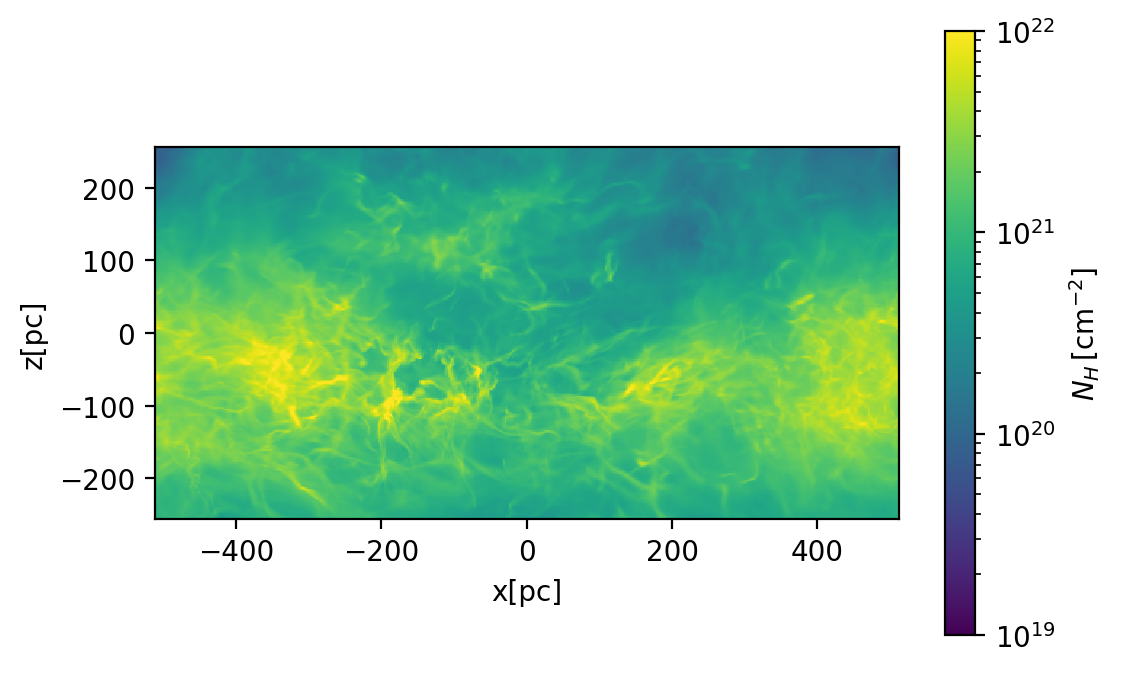

In [9]:
# integration along the y-axis (edge on view)
dy = domain['dx'][1]*ac.pc
NH = nH.sum(axis=1)*dy.cgs.value

plt.pcolormesh(xcc,zcc,NH,norm=LogNorm(1.e19,1.e22),shading='nearest')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
cbar = plt.colorbar(label=r'$N_H\,[{\rm cm^{-2}}]$')

# Data handling example using [xarray](https://docs.xarray.dev/en/stable/)

In [10]:
import xarray as xr
dataset = xr.Dataset()
for f in domain['fields']:
    # read in as numpy array and store it as xarray.DataArray
    da = xr.DataArray(read_data(ds,f,domain),coords=[zcc,ycc,xcc],dims=['z','y','x'])
    dataset[f] = da
dataset

<xarray.Dataset>
Dimensions:      (z: 256, y: 512, x: 512)
Coordinates:
  * z            (z) float64 -255.0 -253.0 -251.0 -249.0 ... 251.0 253.0 255.0
  * y            (y) float64 -511.0 -509.0 -507.0 -505.0 ... 507.0 509.0 511.0
  * x            (x) float64 -511.0 -509.0 -507.0 -505.0 ... 507.0 509.0 511.0
Data variables:
    density      (z, y, x) float32 0.1135 0.1113 0.1106 ... 0.006305 0.002446
    temperature  (z, y, x) float32 7.537e+03 7.438e+03 ... 1.012e+05 2.831e+05
    velocity1    (z, y, x) float32 -3.747 -3.49 -3.236 ... 2.388 -0.7851 0.7355
    velocity2    (z, y, x) float32 14.14 15.86 17.33 ... -26.89 -28.15 -32.24
    velocity3    (z, y, x) float32 2.593 2.612 2.57 ... -11.88 -11.65 -11.69

Text(0, 0.5, 'z[pc]')

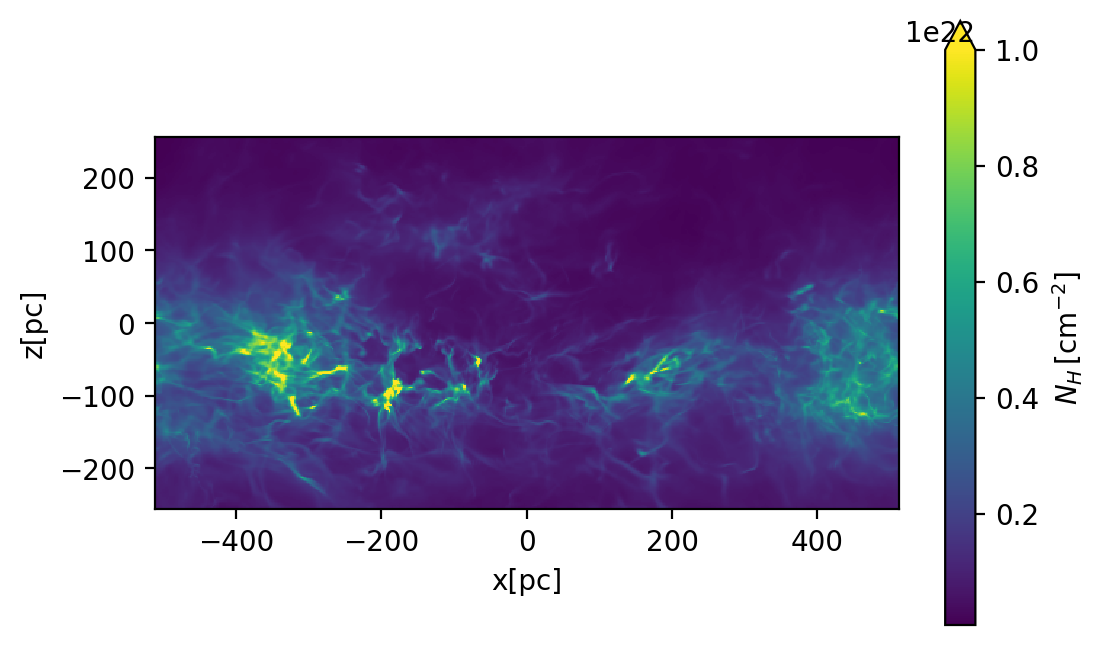

In [11]:
# integration along the y-axis (edge on view)
dy = domain['dx'][1]*ac.pc
NH = dataset['density'].sum(dim='y')*dy.cgs.value

NH.plot(vmax=1.e22,cbar_kwargs=dict(label=r'$N_H\,[{\rm cm^{-2}}]$'))
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')

# LOS information at maximum N_H (along y)

Text(0, 0.5, 'z[pc]')

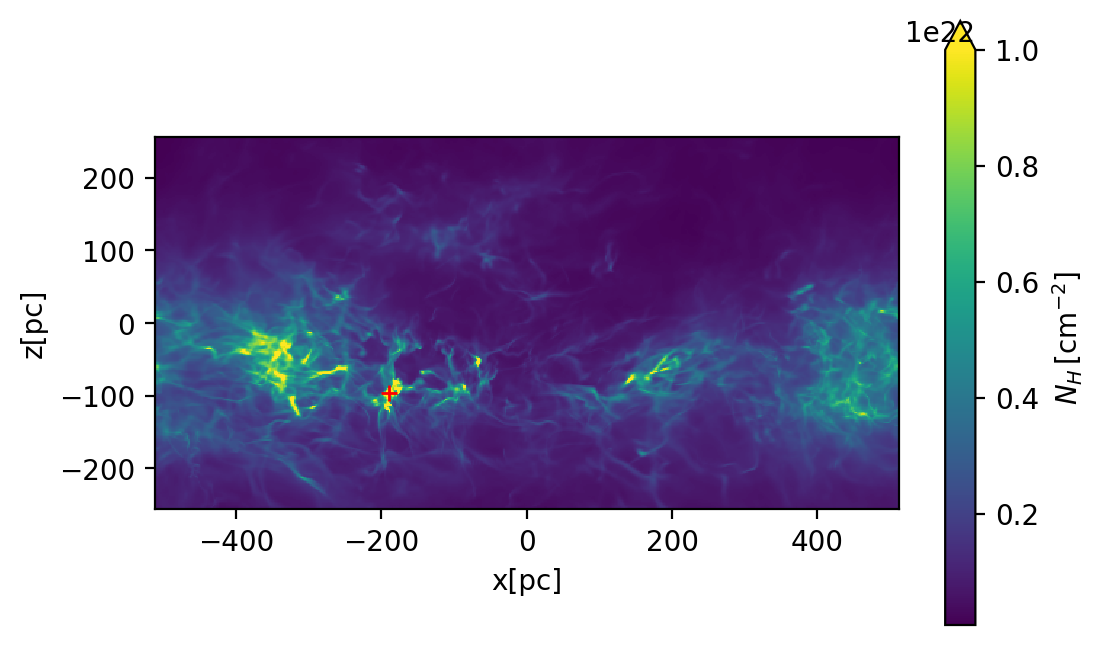

In [12]:
NHmax=NH.where(NH == NH.max(),drop=True)

# integration along the y-axis (edge on view)
dy = domain['dx'][1]*ac.pc
NH = dataset['density'].sum(dim='y')*dy.cgs.value

NH.plot(vmax=1.e22,cbar_kwargs=dict(label=r'$N_H\,[{\rm cm^{-2}}]$'))
plt.plot(NHmax.x,NHmax.z,'r+')
plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')

In [13]:
los=dataset[['density','temperature','velocity2']].sel(x=NHmax.x,z=NHmax.z).squeeze()

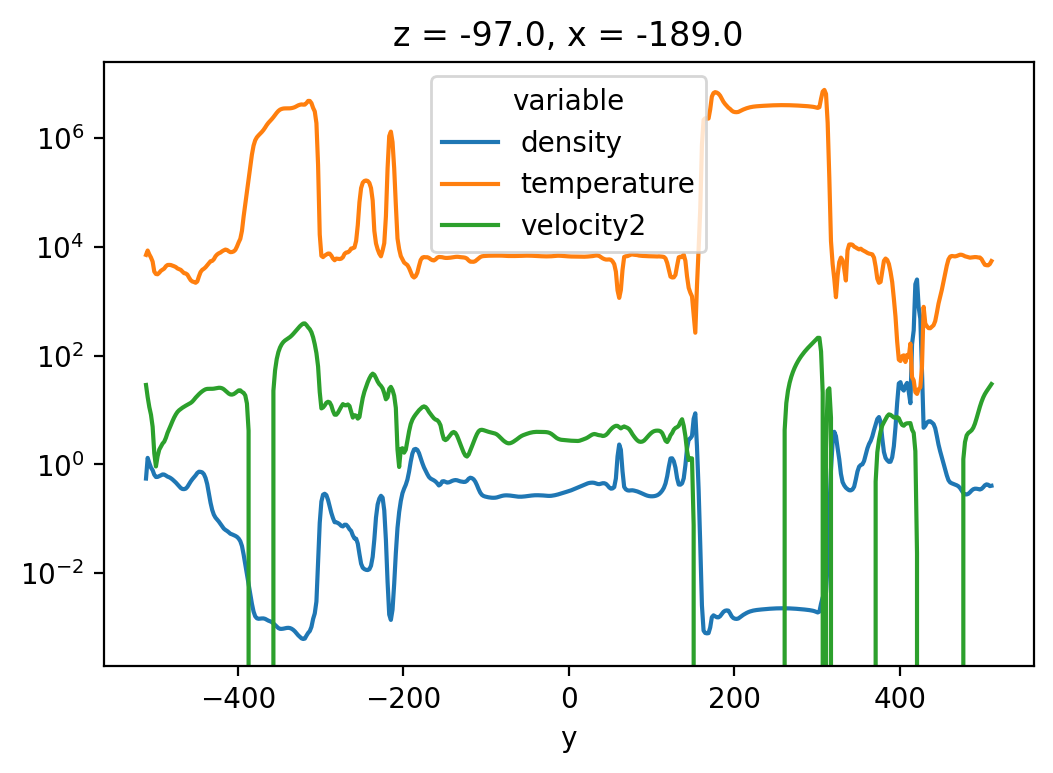

In [14]:
los.to_array().plot(hue='variable',yscale='log')

## we are only interested in HI (T<1.e4)

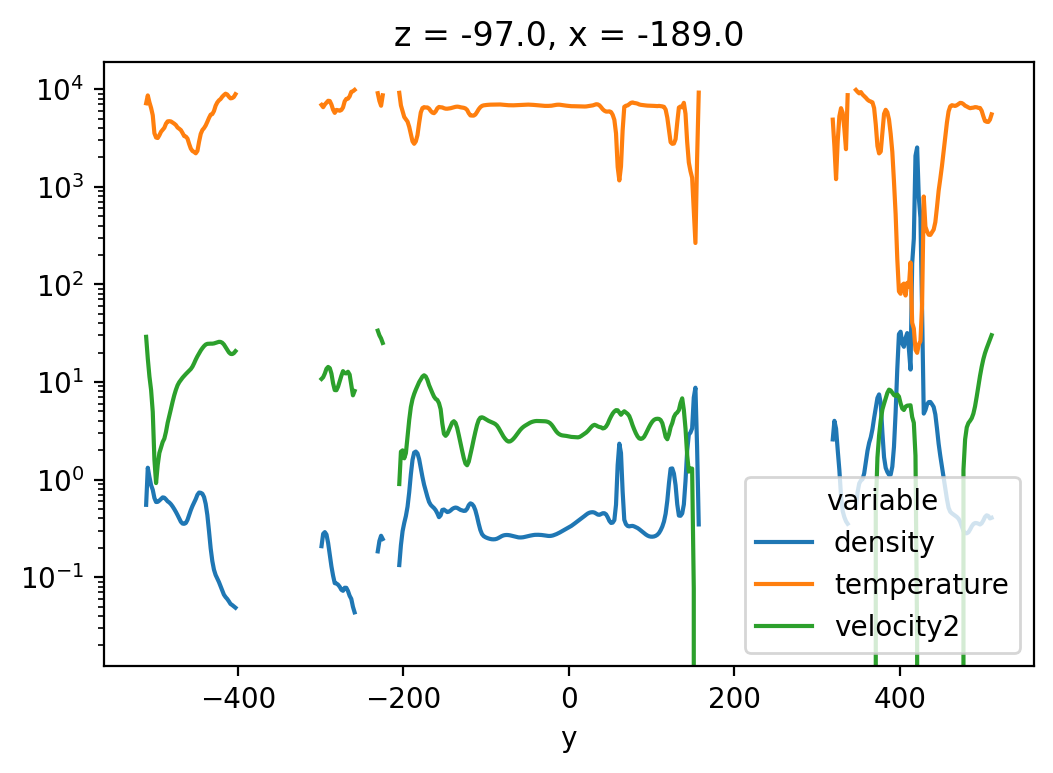

In [15]:
los.where(los['temperature']<1.e4).to_array().plot(hue='variable',yscale='log')

## there seems to be a cloud at y~400pc 

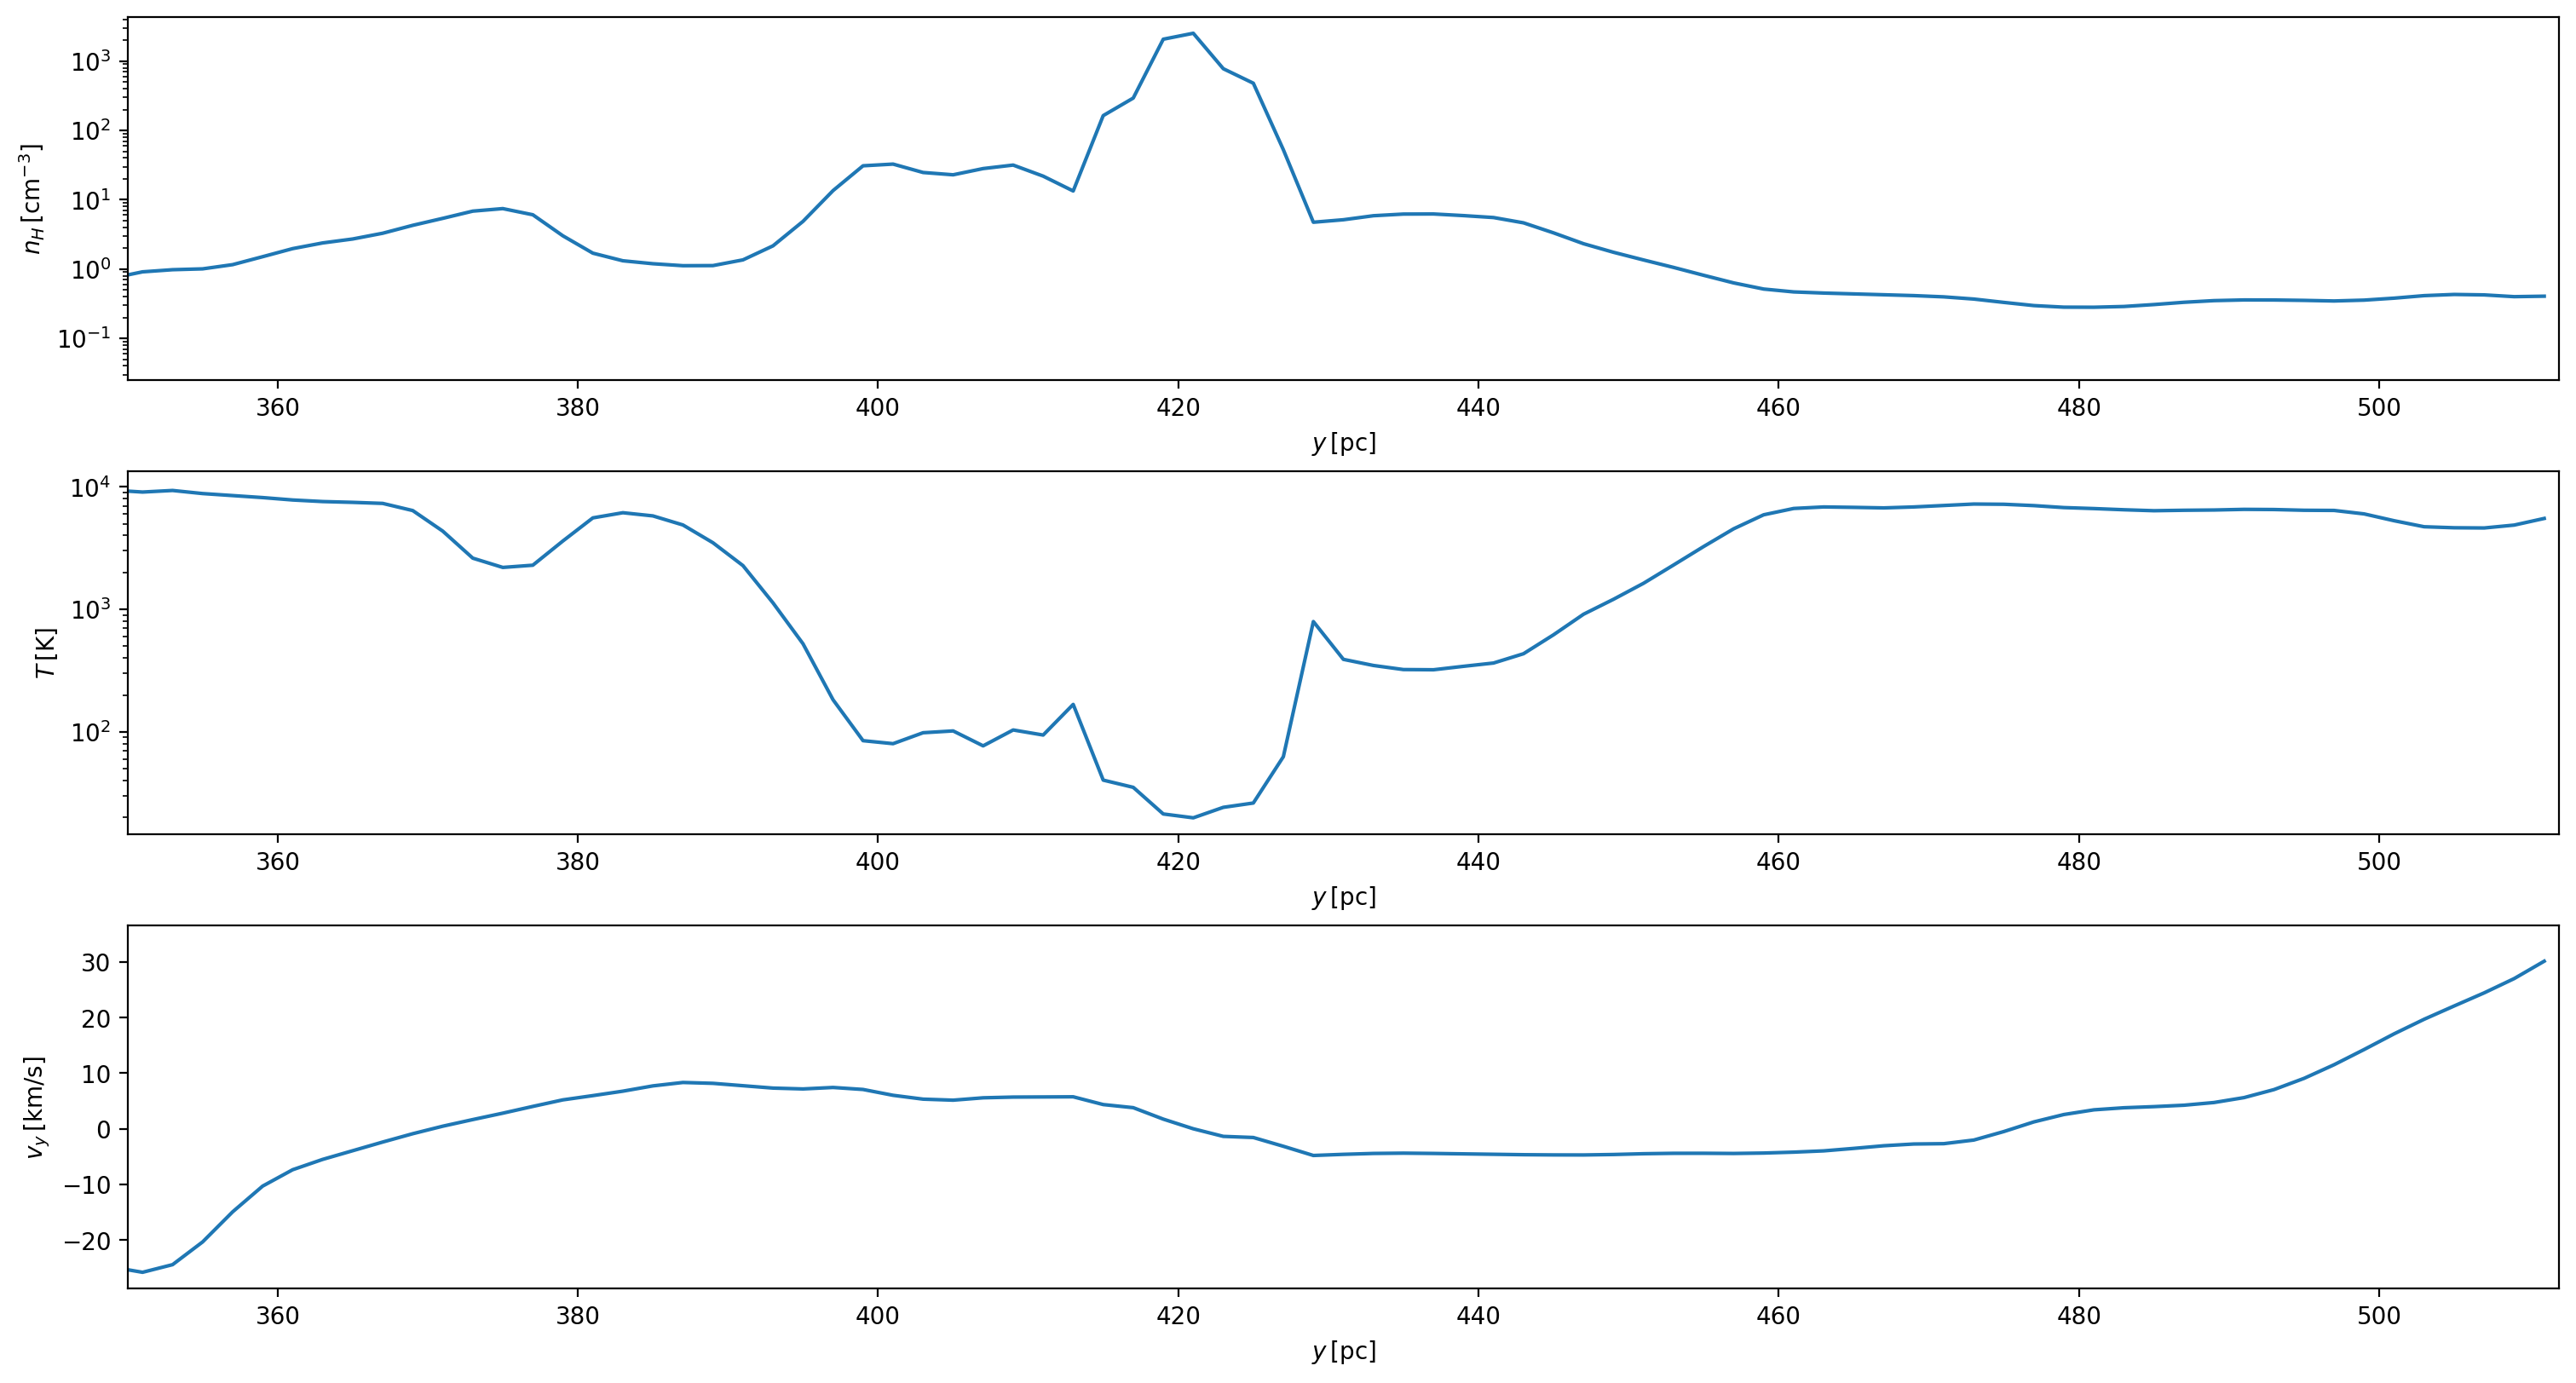

In [16]:
fig,axes = plt.subplots(3,1,figsize=(15,8),constrained_layout=True)
logs = dict(density=True,temperature=True,velocity2=False)
labels = dict(density=r'$n_H\,[{\rm cm}^{-3}]$',
             temperature=r'$T\,[{\rm K}]$',
             velocity2=r'$v_y\,[{\rm km/s}]$')
for f, ax in zip(list(los.variables),axes):
    plt.sca(ax)
    plt.plot(los.y,los[f].where(los['temperature']<1.e4))
    if logs[f]: plt.yscale('log')
    plt.xlim(350,512)
    plt.ylabel(labels[f])
    plt.xlabel(r'$y\,[{\rm pc}]$')

# Maybe some dense gas is molecular (n>50pcc)

(-150.0, 0.0)

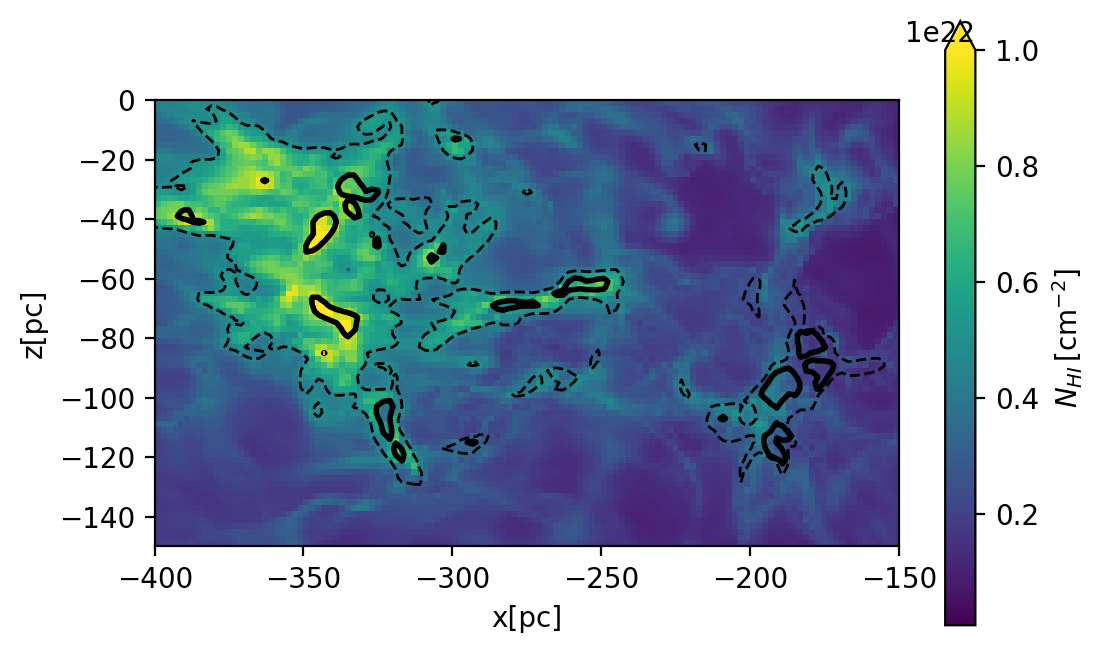

In [17]:
# set threshold density to exclude (assuming that they are molecular)
nth_mol = 50

# integration along the y-axis (edge on view)
dy = domain['dx'][1]*ac.pc
NH = dataset['density'].sum(dim='y')*dy.cgs.value

# integration along the y-axis excluding molecular gas
NHI = dataset['density'].where(dataset['density']<nth_mol).sum(dim='y')*dy.cgs.value

NHI.plot(vmax=1.e22,cbar_kwargs=dict(label=r'$N_{HI}\,[{\rm cm^{-2}}]$'))
NH.plot.contour(levels=[5.e21,1.e22],colors=['k','k'],linestyles=['--','-'],linewidths=[1,2])


plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
plt.xlim(-400,-150)
plt.ylim(-150,0)

# Select LOSs with large NHI 

In [18]:
# set thershold HI column density
NHI_thresh=10.e21

# define a region of interest
xmin,xmax = -400,-300
zmin,zmax = -150,0
# find x,y pairs that satisfy the thershold condition within the regions of interest
xzpair=NHI.sel(x=slice(xmin,xmax),z=slice(xmin,zmax))
xzpair=xzpair.where(NHI > NHI_thresh,drop=True).stack(xz=['x','z']).dropna(dim='xz').xz
print("There are a total of {} LOSs satisfying our criteria".format(len(xzpair)))

# set number of los to choose (randomly selected within LOSs satisfying the threshold condition)
Nlos=10
idx=(np.random.rand(Nlos)*len(xzpair)).astype('int')
idx.sort()
xzpair_sel=xzpair.sortby('z').data[idx]

There are a total of 24 LOSs satisfying our criteria


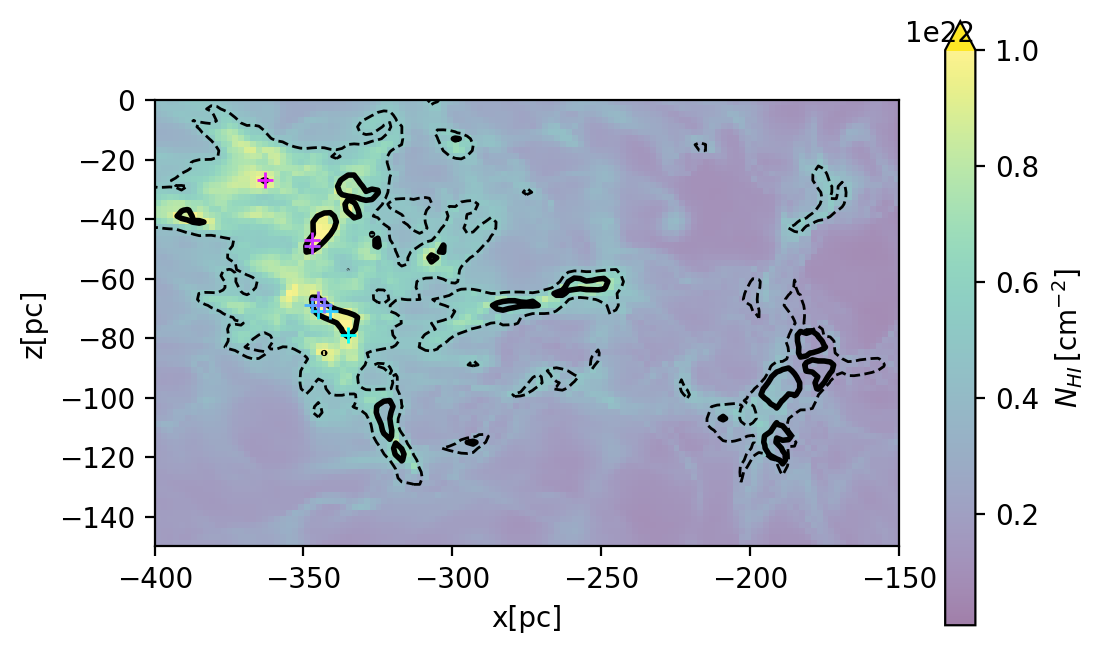

In [19]:
# set threshold density to exclude (assuming that they are molecular)
nth_mol = 50

# integration along the y-axis (edge on view)
dy = domain['dx'][1]*ac.pc
NH = dataset['density'].sum(dim='y')*dy.cgs.value

# integration along the y-axis excluding molecular gas
NHI = dataset['density'].where(dataset['density']<nth_mol).sum(dim='y')*dy.cgs.value

NHI.plot.imshow(vmax=1.e22,cbar_kwargs=dict(label=r'$N_{HI}\,[{\rm cm^{-2}}]$'),alpha=0.5)
NH.plot.contour(levels=[5.e21,1.e22],colors=['k','k'],linestyles=['--','-'],linewidths=[1,2])

plt.gca().set_aspect('equal')
plt.xlabel('x[pc]')
plt.ylabel('z[pc]')
plt.xlim(-400,-150)
plt.ylim(-150,0)

# now add LOSs
for i,(x,z) in enumerate(xzpair_sel):
    plt.plot(x,z,'+',color=plt.cm.cool(i/Nlos))

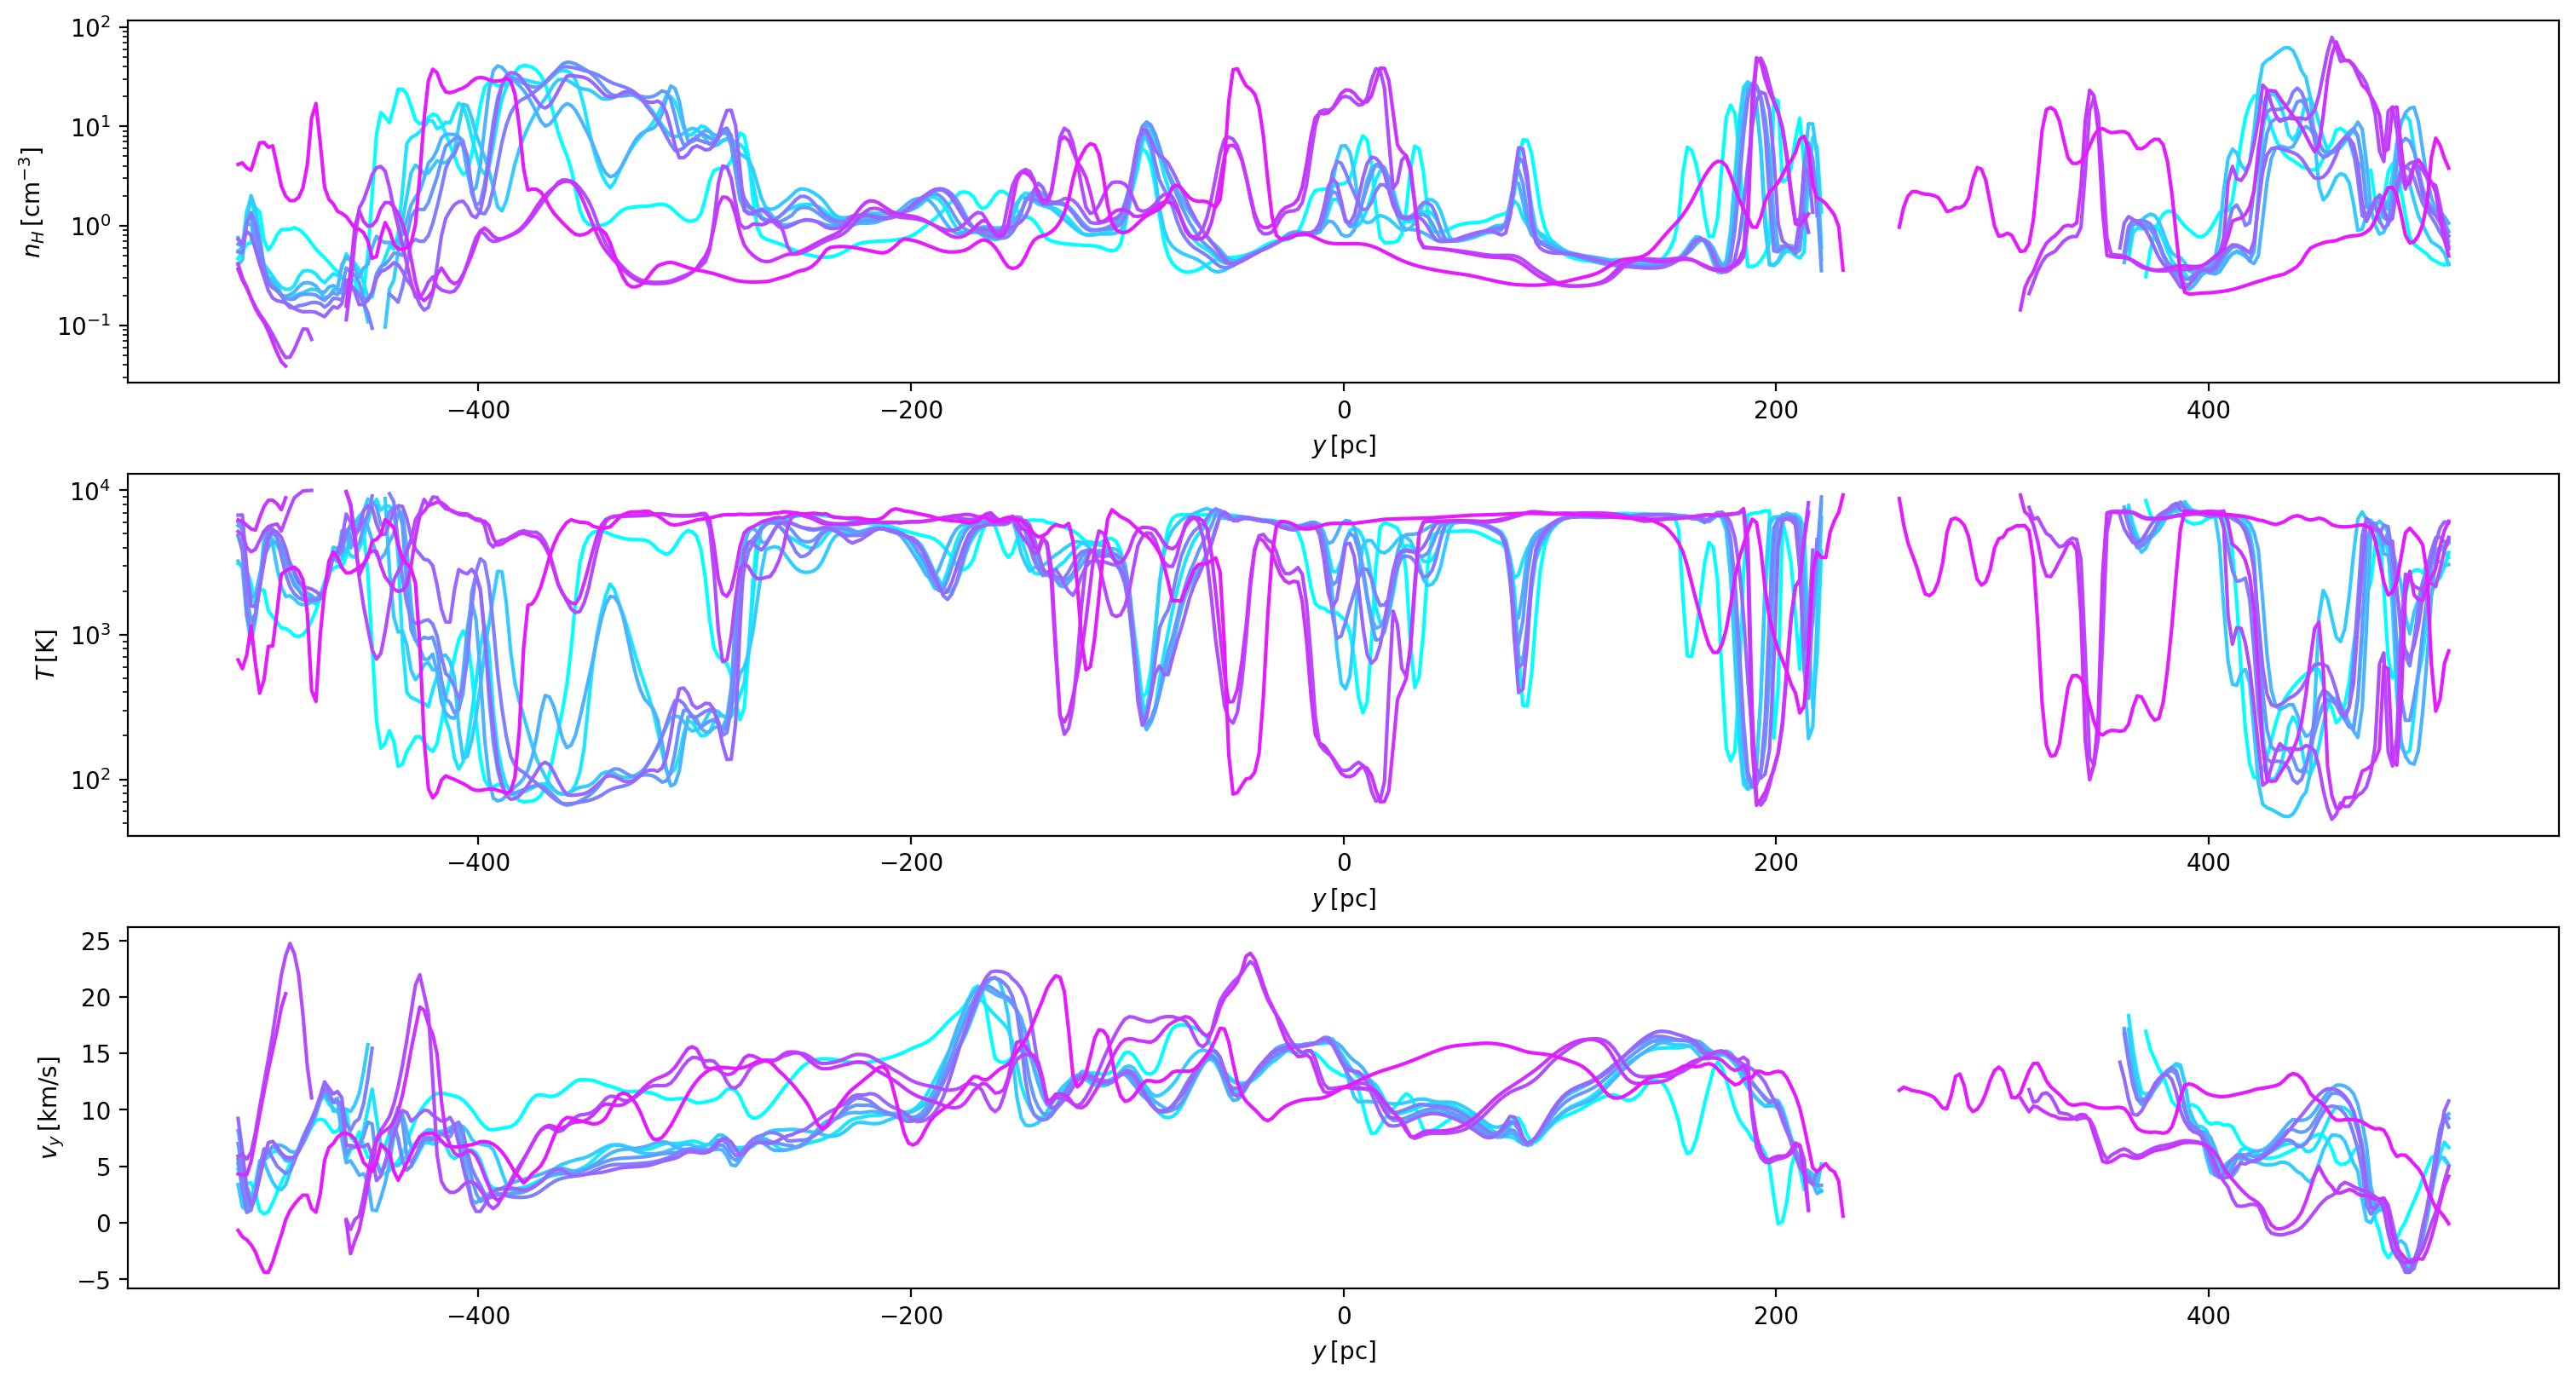

In [20]:
fig,axes = plt.subplots(3,1,figsize=(15,8),constrained_layout=True)
logs = dict(density=True,temperature=True,velocity2=False)
labels = dict(density=r'$n_H\,[{\rm cm}^{-3}]$',
             temperature=r'$T\,[{\rm K}]$',
             velocity2=r'$v_y\,[{\rm km/s}]$')

for i,(x,z) in enumerate(xzpair_sel):
    los=dataset[['density','temperature','velocity2']].sel(x=x,z=z).squeeze()
    for f, ax in zip(list(los.variables),axes):
        plt.sca(ax)
        plt.plot(los.y,los[f].where(los['temperature']<1.e4),color=plt.cm.cool(i/Nlos))
        if logs[f]: plt.yscale('log')
#         plt.xlim(350,512)
        plt.ylabel(labels[f])
        plt.xlabel(r'$y\,[{\rm pc}]$')

# Synthetic HI

* Following the method presented in https://ui.adsabs.harvard.edu/abs/2014ApJ...786...64K/abstract
* Assuming that the WF effect is efficient enough to make T_spin = T_k based on Ly alpha radiation transfer study https://ui.adsabs.harvard.edu/abs/2020ApJS..250....9S/abstract
* $$N_H = 1.813\times10^{18}{\rm cm^{-2}}\int T_B \frac{\tau}{1-e^{-\tau}} d(v/(km/s))$$

In [21]:
from synthetic_HI import los_to_HI_axis_proj

In [22]:
help(los_to_HI_axis_proj)

Help on function los_to_HI_axis_proj in module synthetic_HI:

los_to_HI_axis_proj(dens, temp, vel, vchannel, memlim=1.0, deltas=1.0, los_axis=1, verbose=False)
    inputs:
        dens: number density of hydrogen in units of 1/cm^3
        temp: temperature in units of K
        vel: line-of-sight velocity in units of km/s
        vchannel: velocity channel in km/s
    parameters:
        deltas: length of line segments in units of pc
        memlim: memory limit in GB
        los_axis: 0 -- z, 1 -- y, 2 -- x
    outputs: a dictionary
        TB: the brightness temperature
        tau: optical depth



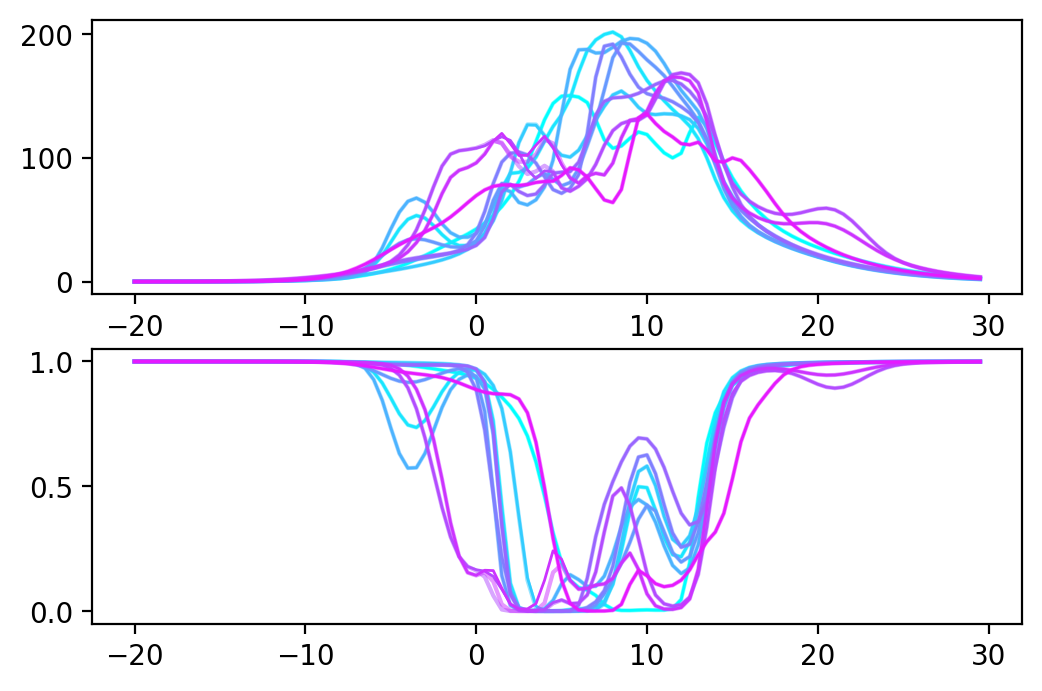

In [23]:
delta_s = domain['dx'][1]
fig,axes = plt.subplots(2,1)
for i,(x,z) in enumerate(xzpair_sel):
    los=dataset[['density','temperature','velocity2']].sel(x=x,z=z).squeeze()

    vch = np.arange(-20,30,0.5) # velocity resolution of 1km/s
    TB,tau = los_to_HI_axis_proj(los['density'],los['temperature'],los['velocity2'],
                                 vch,deltas=delta_s,memlim=0,
                                 los_axis=0,verbose=False)


    plt.sca(axes[0])
    plt.plot(vch,TB,color=plt.cm.cool(i/Nlos),alpha=0.5);
    plt.sca(axes[1])
    plt.plot(vch,np.exp(-tau),color=plt.cm.cool(i/Nlos),alpha=0.5);
    
    los = los.where((los['density']<nth_mol) & (los['temperature']<1.e4))
    TB,tau = los_to_HI_axis_proj(los['density'],los['temperature'],los['velocity2'],
                                 vch,deltas=delta_s,memlim=0,
                                 los_axis=0,verbose=False)

    plt.sca(axes[0])
    plt.plot(vch,TB,color=plt.cm.cool(i/Nlos),lw=1);
    plt.sca(axes[1])
    plt.plot(vch,np.exp(-tau),color=plt.cm.cool(i/Nlos),lw=1);    

# Make a PPV cube for a selected region

In [24]:
# select a region of interest
xmin, xmax = -450,-150
zmin, zmax = -150,0

dsel = dataset.sel(x=slice(xmin,xmax),z=slice(zmin,zmax))

In [25]:
def plot_column_density(dset,
                        los_axis='y', # los direction
                        ds=2*ac.pc.cgs.value,   # data spacing along the los
                        nth_mol=50,   # threshold density to exclude (above which it will be molecular)
                        draw=True,
                       ):

    # total hydrogen column
    NHtot = dset['density'].sum(dim=los_axis)*ds
    # atomic hydrogen column
    NHI = dset['density'].where(dset['density']<nth_mol).sum(dim=los_axis)*ds

    if draw:
        NHI.plot.imshow(vmax=1.e22,cbar_kwargs=dict(label=r'$N_{HI}\,[{\rm cm^{-2}}]$',orientation='horizontal'))
        NHtot.plot.contour(levels=[5.e21,1.e22],colors=['k','k'],linestyles=['--','-'],linewidths=[1,2])
        ylabel,xlabel = NHI.dims
        plt.gca().set_aspect('equal')
        plt.xlabel('{}[pc]'.format(xlabel))
        plt.ylabel('{}[pc]'.format(ylabel))
    return NHI,NHtot

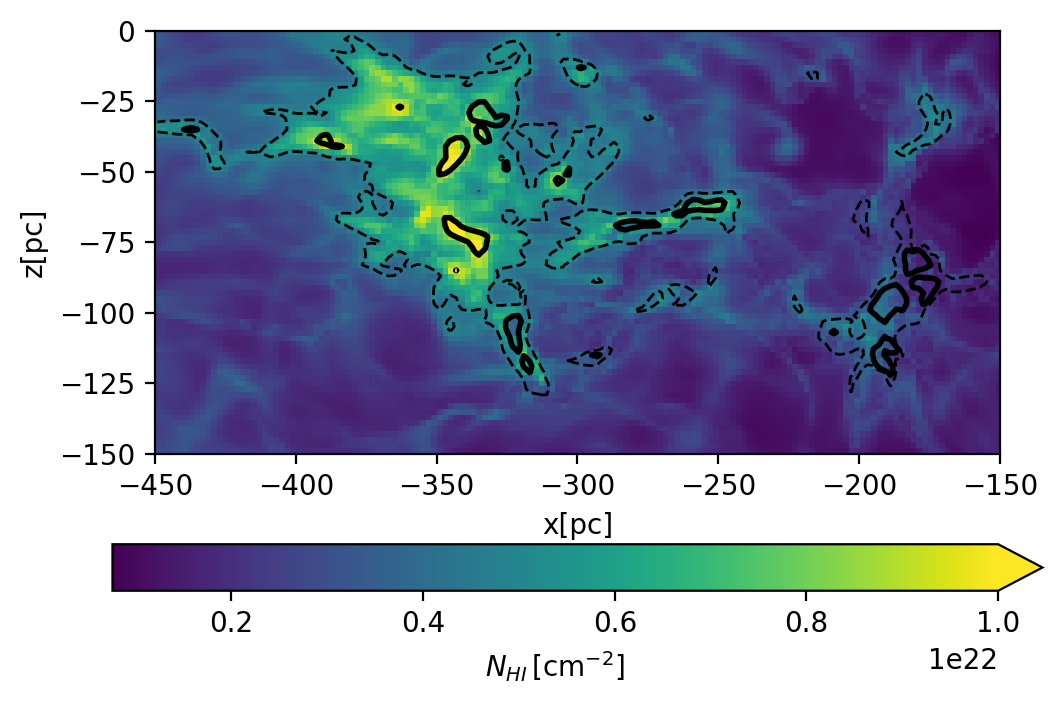

In [26]:
NHI,NHtot=plot_column_density(dsel)

In [27]:
# this will take some time

vmin,vmax,dv=-50,50,0.5
vch = np.arange(vmin,vmax+0.5*dv,dv) # velocity resolution of 0.5 km/s
nth_mol = 50 # threshold density above which gas is considered as H2
Tth = 1.e4 # threshold temperature below which gas is considered as HI
los = dsel.where((dsel['density']<nth_mol) & (dsel['temperature']<Tth))
TB,tau = los_to_HI_axis_proj(los['density'],los['temperature'],los['velocity2'],
                             vch,deltas=delta_s,
                             memlim=0, # with non-zero value, it will chunk data and do the los integration chunk-by-chunk
                             los_axis=1, # axis along which the integration is performed (0='z', 1='y', 2='x')
                             verbose=False)

In [28]:
# save to fits file for future use
from synthetic_HI import save_to_fits
fitsname = fname.replace('vtk','xz.HI.ROI1.fits')
hdu = save_to_fits(domain,vch,TB,tau,fitsname)

In [29]:
# reconstruct column density from synthetic observation
NHobs = 1.813e18*(TB*(tau+1.e-4)/(1-np.exp(-(tau+1.e-4)))).sum(axis=0)*dv
NHthin = 1.813e18*TB.sum(axis=0)*dv

Text(0, 0.5, '$N_{\\rm HI,syn}$')

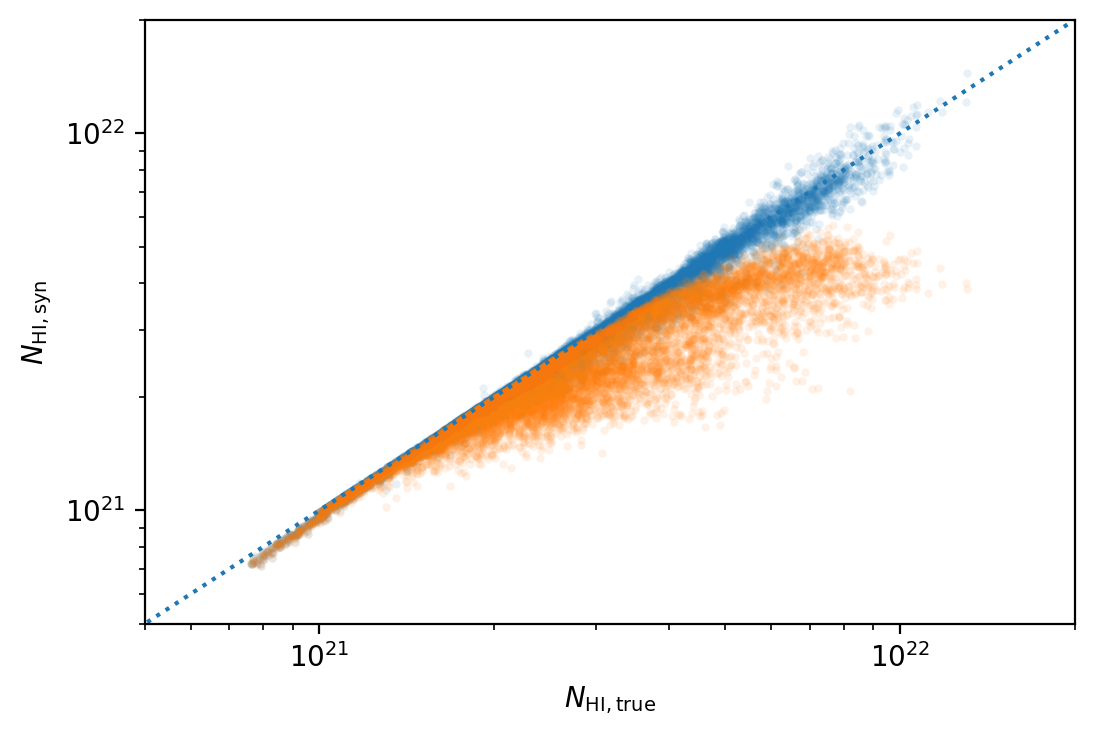

In [30]:
# comparison between true and observed
plt.scatter(NHI,NHobs,marker='.',alpha=0.1,lw=0)
plt.scatter(NHI,NHthin,marker='.',alpha=0.1,lw=0)
plt.plot([1.e20,1.e23],[1.e20,1.e23],ls=':')
plt.xlim(5.e20,2.e22)
plt.ylim(5.e20,2.e22)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$N_{\rm HI,true}$')
plt.ylabel(r'$N_{\rm HI,syn}$')


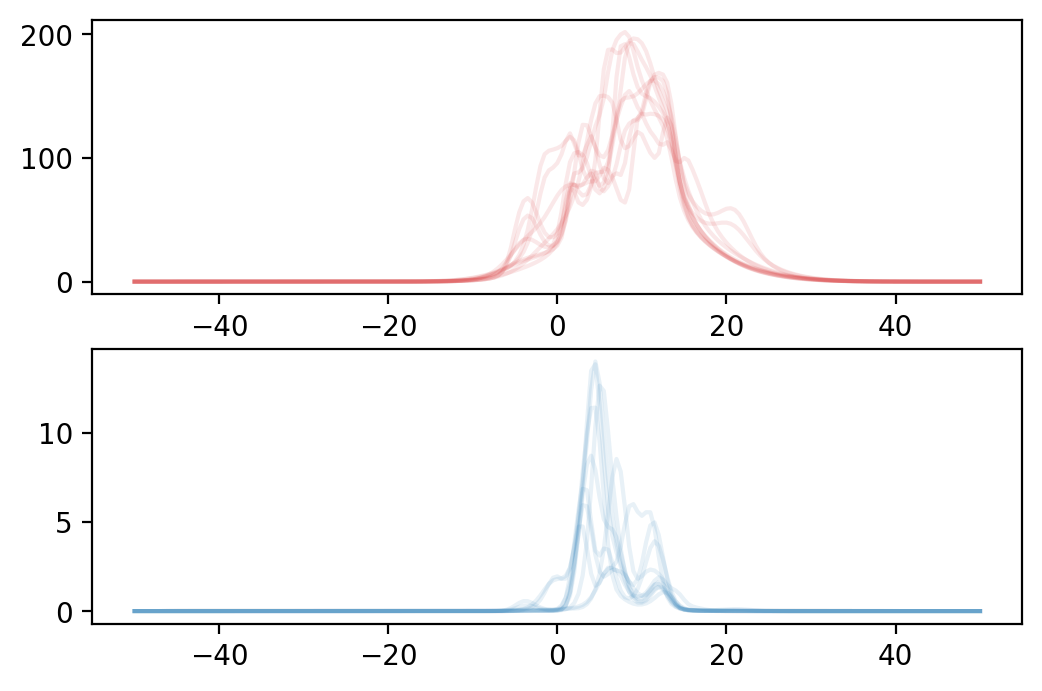

In [31]:
fig,axes = plt.subplots(2,1)
for (x,z) in xzpair_sel:
    i=int((x-xmin-0.5*domain['dx'][0])/domain['dx'][0])
    k=int((z-zmin-0.5*domain['dx'][2])/domain['dx'][2])
    plt.sca(axes[0])
    plt.plot(vch,TB[:,k,i],color='tab:red',alpha=0.1);
    plt.sca(axes[1])
    plt.plot(vch,tau[:,k,i],color='tab:blue',alpha=0.1);

# Reading from fits file

In [32]:
from astropy.io import fits

In [33]:
hdu=fits.open(fitsname)

In [34]:
vmin,vmax,dv=hdu[0].header['vmin'],hdu[0].header['vmax'],hdu[0].header['dv']
vch = np.arange(vmin,vmax+0.5*dv,dv)

In [35]:
TB=hdu[1].data
tau=hdu[2].data

In [36]:
NHobs = 1.813e18*(TB*(tau+1.e-4)/(1-np.exp(-(tau+1.e-4)))).sum(axis=0)*dv

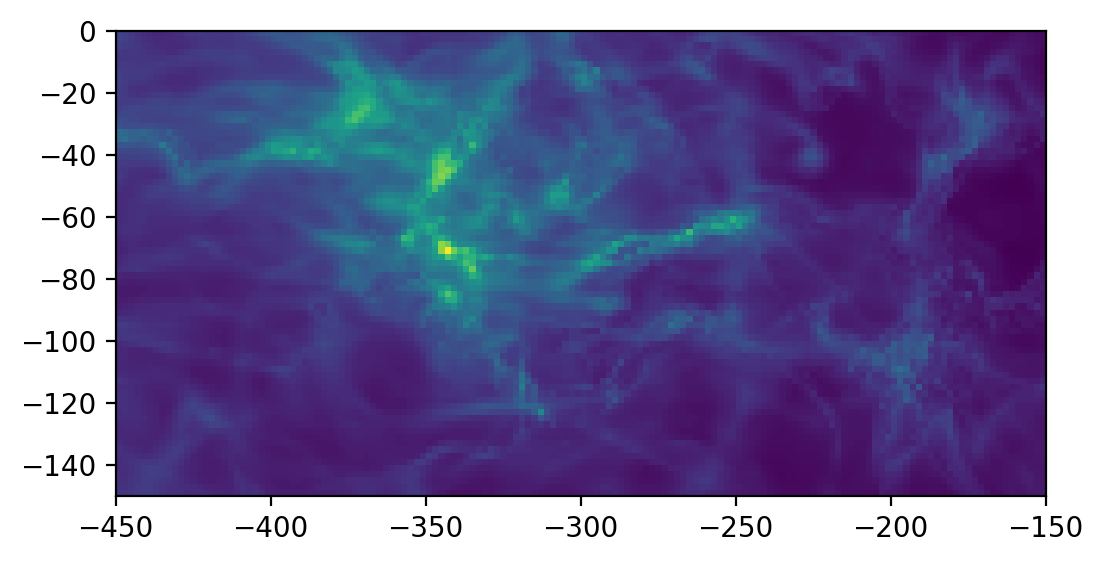

In [37]:
plt.imshow(NHobs,extent=[xmin,xmax,zmin,zmax],origin='lower')
plt.gca().set_aspect('equal')

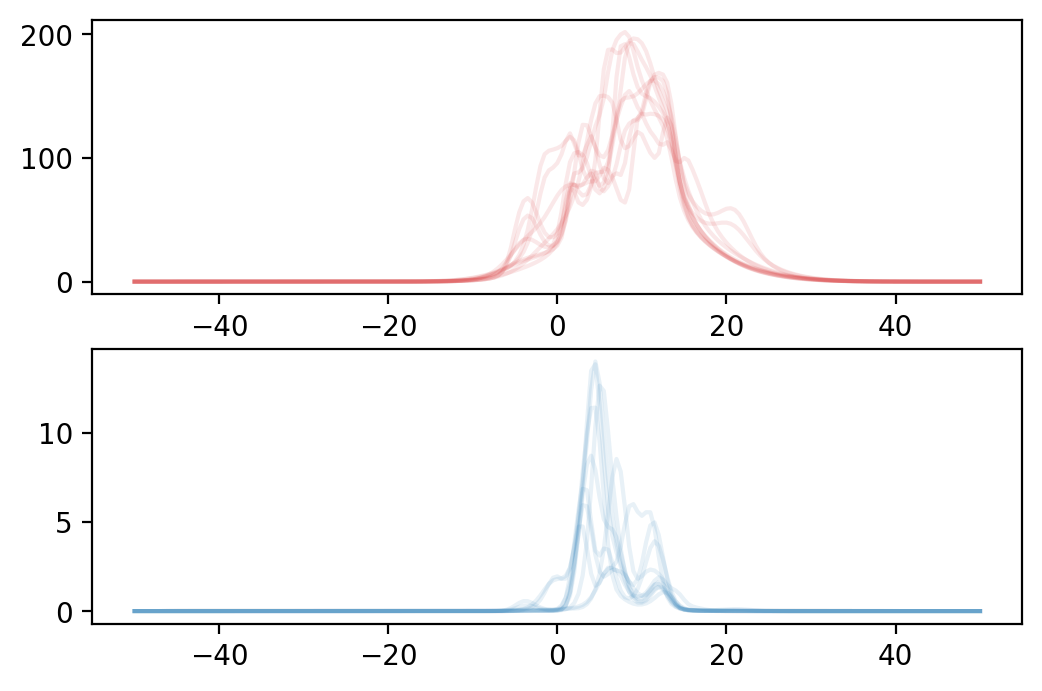

In [38]:
fig,axes = plt.subplots(2,1)
for (x,z) in xzpair_sel:
    i=int((x-xmin-0.5*domain['dx'][0])/domain['dx'][0])
    k=int((z-zmin-0.5*domain['dx'][2])/domain['dx'][2])
    plt.sca(axes[0])
    plt.plot(vch,TB[:,k,i],color='tab:red',alpha=0.1);
    plt.sca(axes[1])
    plt.plot(vch,tau[:,k,i],color='tab:blue',alpha=0.1);